## Introduction
This is a script to identify users that are likely to spend money in their game after finishing the tutorial. Before start make sure to do the following steps: 

* Move all `*.db`, `*.parquet`, `*.csv` files to the `data` folder.
* Create a conda environment with using the `.yml` file using `conda env -n myenv create -f conda_env.yml`
* Activate your environment using `conda activate myenv` and run `jupyter notebook run_me.ipynb`

In order to make make this notebook cleaner, I prepared a python package called `amin_helper_package` in which some classes for data and model managements are implemented.


## Step1: Loading Data
The first step is to load users, users' actions and users' devices in different types (`.parquet`, `.db`, `.csv`) using the helper package.

In [1]:
DEBUG = True
import amin_helper_package as helper

df = helper.DataManager(users_path='./data/ka_users.csv',
                                  actions_path='./data/ka_actions.parquet',
                                  devices_path='./data/ka_devices.db',
                                  merge_on='uid_s').get_merged_data()

df = df.drop(columns=['uid_s', 'index'])

if DEBUG: 
    df = df.sample(frac=0.1)

print(df.shape)
df.describe()

(284593, 28)


,tz_i,local_time_join_hour,local_time_join_dow,total_spend,logins,game_stats_tutorial_complete,game_stats_tutorial_complete_time,game_stats_xp,game_stats_xp1,game_stats_xp2,game_stats_xp3,redeemer_actions,scribe_actions,device_mem_i,device_gmem_i,device_mem_grouping_i,device_gmem_grouping_i,device_numcpu_i,device_height_i
count,284593.000000,284593.000000,284593.000000,284593.000000,284588.000000,175296.000000,1.747930e+05,208055.000000,208055.000000,208055.000000,208055.000000,283556.000000,284593.000000,284593.000000,284593.000000,284593.000000,284593.000000,284593.000000,284593.000000
mean,11134.064436,14.737003,4.215592,1.214524,2.957120,0.997131,1.740687e+09,884.845132,443.759588,128.107198,78.353455,130.845798,133.088147,2661.805333,816.066397,2694.741304,816.066397,5.811102,889.833633
std,19268.866294,5.687322,2.305100,13.876934,2.006879,0.053490,3.793778e+09,2455.714216,582.143063,562.648959,487.773052,226.886001,93.547626,1393.767534,472.374187,1394.975539,472.374187,2.427558,254.609362
min,-39600.000000,0.000000,1.000000,0.000000,1.000000,0.000000,2.430000e+08,10.000000,0.000000,0.000000,0.000000,1.000000,3.000000,397.000000,128.000000,448.000000,128.000000,1.000000,240.000000
25%,-10800.000000,11.000000,2.000000,0.000000,2.000000,1.000000,5.070000e+08,90.000000,80.000000,0.000000,0.000000,25.000000,69.000000,1821.000000,512.000000,1856.000000,512.000000,4.000000,720.000000
50%,19800.000000,16.000000,4.000000,0.000000,2.000000,1.000000,6.360000e+08,313.000000,309.000000,0.000000,0.000000,53.000000,128.000000,2738.000000,1024.000000,2752.000000,1024.000000,8.000000,800.000000
75%,28800.000000,19.000000,7.000000,0.000000,3.000000,1.000000,9.410000e+08,829.000000,595.000000,0.000000,0.000000,134.000000,167.000000,3595.000000,1024.000000,3648.000000,1024.000000,8.000000,1080.000000
max,41400.000000,23.000000,7.000000,405.000000,300.000000,1.000000,2.880000e+10,210971.000000,26843.000000,31095.000000,22382.000000,6210.000000,2222.000000,15488.000000,4096.000000,15488.000000,4096.000000,16.000000,2560.000000


## Step2: Exploratory Data Analysis

In [2]:
# Loading other libraries
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Firstly, to handle the missing values, we can see that most of the missing values come from users' behaviours and action database
print(df.isnull().sum())

# It is valuable to keep the data as much as possible. To fill the NaN values in actions, 
#let's fill with the minimum values (not mean because it's safer to consider a user made no action at all than having the average activity)
high_missing_columns = ['game_stats_tutorial_complete', 
                        'game_stats_tutorial_complete_time', 
                        'game_stats_xp',
                        'game_stats_xp1',
                        'game_stats_xp2',
                        'game_stats_xp3',
                        'redeemer_actions'
                       ]
for missing_column in tqdm(high_missing_columns, desc='Filling the missing values'):
    min_value = df[missing_column].min()
    df[missing_column].fillna(min_value, inplace = True)
    
# The remaining NaN values are not that much, so let's remove them    
df = df.dropna()

lang_s                                    0
geo_s                                    22
region_s                                  0
tz_i                                      0
local_time_join_hour                      0
local_time_join_dow                       0
total_spend                               0
logins                                    5
game_stats_tutorial_complete         109297
game_stats_tutorial_complete_time    109800
game_stats_xp                         76538
game_stats_xp1                        76538
game_stats_xp2                        76538
game_stats_xp3                        76538
redeemer_actions                       1037
scribe_actions                            0
platform_s                                0
device_mapped_s                           0
device_manufacturer_s                     0
device_mem_i                              0
device_gmem_i                             0
device_mem_grouping_i                     0
device_gmem_grouping_i          

Filling the missing values: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 107.86it/s]


In order to handle categorical features, let's use the `rearrange_categorical_features()` in the helper package. For more details, please see the code. The basic idea is to convert some of them to encode target labels with value between 0 and `n_classes-1`. For mobile devices, it doesn't make sense to store a long string for each device separately (`'device_os_s'`). So instead, let's keep track of Android devices with label `0` and iPhone devices with label `1`. Other information we extract from `device_os_s` is to see how updated the operating system is. Since iOS and Android versions are following different numbers, assign a float number to the version of the operating system between `[0-1]`. To get this feature, we can convert the version to a float number divided by the maximum version seen in those types of devices. For example, if we have a maximum iOS version 15, a device `iOS os: 10.1.0` will be mapped to `(1, 0.677)`.

In [4]:
# Handling categorical features
# First, let's remove some unnecessary features. In platform, the version of the operating system
df = helper.fe.rearrange_categorial_features(df)

Removing categorical features: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.39it/s]


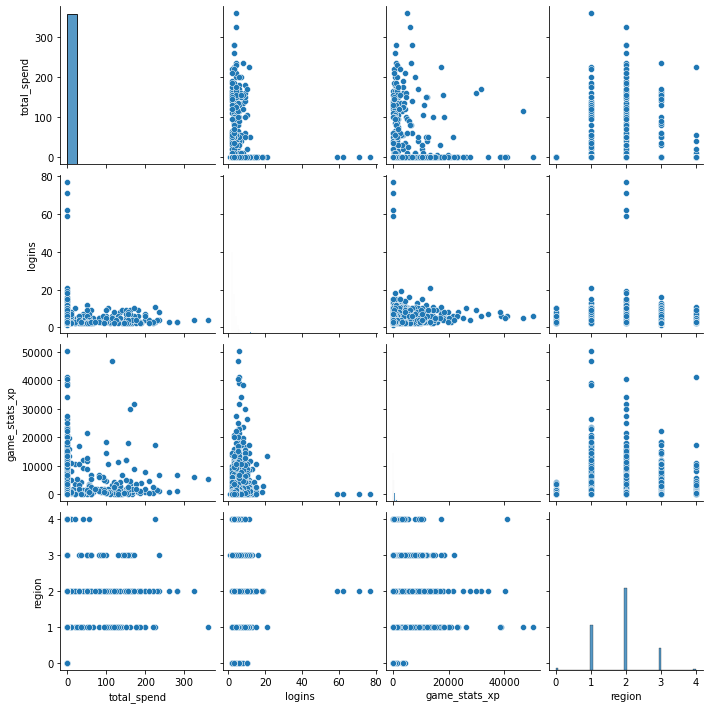

In [5]:
# plot the pair plot of some columns in data dataframe.
# Notes to observe from this pairplot: 
# Some columns like region is not balanced, we have lots of users from Asia 
sns.pairplot(data = df.sample(frac=0.05), vars=['total_spend','logins','game_stats_xp', 'region'])
plt.show()

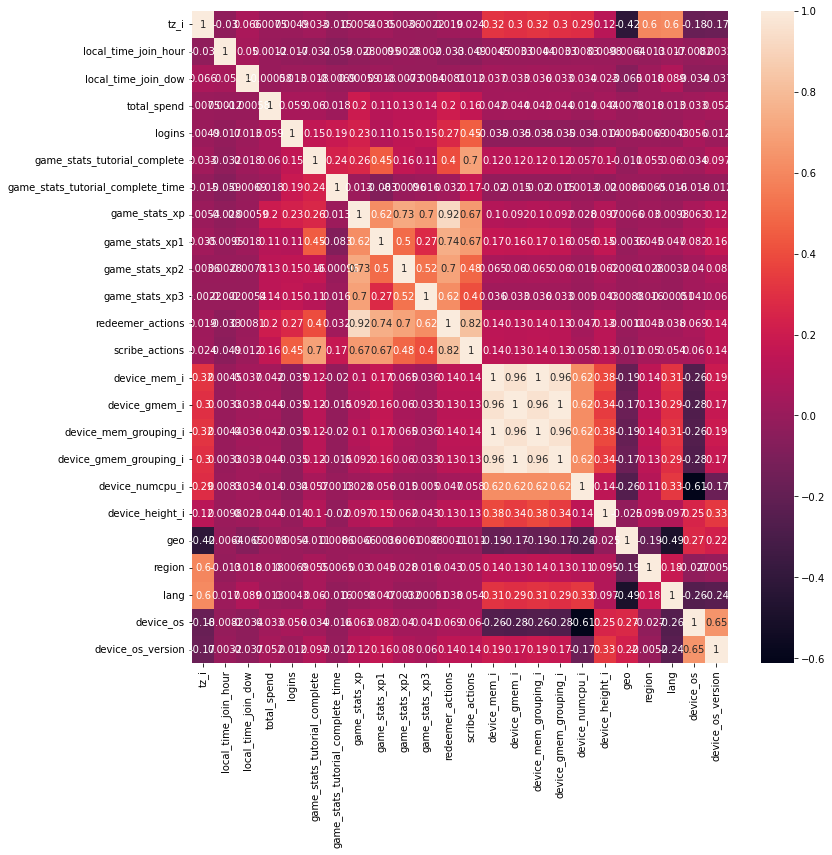

In [6]:
# To find what columns are correlated, lets create the 2D matrix of correlations
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(df.sample(frac=0.05).corr(), annot=True, ax=ax)
plt.show()

Correlated features in general don't improve models, and also it is always better to make the model simpler. Let's remove highly correlated features: 

In [7]:
feature_remove_list = [
    'device_gmem_i', 'device_mem_grouping_i', 'device_gmem_grouping_i', 
    'logins', 'redeemer_actions', 'game_stats_xp'
]
df = df.drop(columns = feature_remove_list)

## Step3: Preparing training/test sets

In [10]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

all_features = list(df.columns)

# Normalize all columns:
scaler = MinMaxScaler()
df[all_features] = scaler.fit_transform(df)

target_feature = 'total_spend'
training_features = list(df.columns)
training_features.remove(target_feature)

df, df_test = train_test_split(df, test_size=0.2, shuffle=True)

In [14]:
df

,tz_i,local_time_join_hour,local_time_join_dow,total_spend,logins,game_stats_tutorial_complete,game_stats_tutorial_complete_time,game_stats_xp,game_stats_xp1,game_stats_xp2,...,device_gmem_i,device_mem_grouping_i,device_gmem_grouping_i,device_numcpu_i,device_height_i,geo,region,lang,device_os,device_os_version
2273298,0.577778,0.391304,0.000000,0.0,0.010033,1.0,0.007144,0.016240,0.046828,0.045377,...,0.096774,0.102128,0.096774,0.200000,0.206897,0.408163,0.75,0.1250,0.0,0.333333
1576067,0.844444,0.521739,0.666667,0.0,0.006689,1.0,0.824596,0.002801,0.000000,0.000000,...,0.225806,0.212766,0.225806,0.466667,0.206897,0.198980,0.50,0.9375,0.0,0.666667
897907,0.733333,0.652174,0.000000,0.0,0.003344,1.0,0.036383,0.001422,0.011549,0.000000,...,0.096774,0.093617,0.096774,0.200000,0.206897,0.433673,0.50,0.1250,0.0,0.516667
73293,0.844444,0.565217,0.833333,0.0,0.006689,1.0,0.027139,0.004849,0.011660,0.000000,...,0.225806,0.225532,0.225806,0.466667,0.206897,0.198980,0.50,0.9375,0.0,0.183333
2353087,0.355556,0.478261,0.000000,0.0,0.003344,0.0,0.000000,0.000000,0.000000,0.000000,...,0.096774,0.097872,0.096774,0.466667,0.206897,0.137755,0.25,0.1250,0.0,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2479711,0.711111,0.565217,0.166667,0.0,0.010033,1.0,0.008369,0.001749,0.014119,0.000000,...,0.225806,0.157447,0.225806,0.200000,0.517241,0.744898,0.50,0.1250,0.0,0.333333
1498509,0.622222,0.782609,0.500000,0.0,0.003344,0.0,0.000000,0.000000,0.000000,0.000000,...,0.096774,0.106383,0.096774,0.066667,0.219828,0.520408,0.50,0.2500,1.0,0.973118
894323,0.533333,0.478261,0.000000,0.0,0.010033,1.0,0.361768,0.001432,0.002980,0.000000,...,0.225806,0.161702,0.225806,0.466667,0.362069,0.316327,0.75,0.1250,0.0,0.500000
374814,0.844444,0.434783,1.000000,0.0,0.010033,1.0,0.007424,0.031740,0.087285,0.112590,...,0.225806,0.212766,0.225806,0.466667,0.362069,0.198980,0.50,0.9375,0.0,0.516667
